Using ML we will predict if the credit card is fraud or not. The datasets contains transactions made by credit cards in September 2013 by european cardholders. 

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. 

The dataset is highly unbalanced and we will use sampling technique to handle it.The input variables are transformed into numerical using PCA transformations to main tain confidentiality.

In [1]:
import numpy as np
import pandas as pd 
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os

In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<AxesSubplot:xlabel='Class', ylabel='count'>

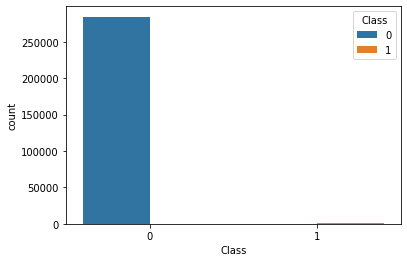

In [3]:
sns.countplot(data=df, x='Class', hue=df.Class)

In [4]:
print(df.shape)
df.drop_duplicates(keep='first', inplace=True)
print(df.shape)

(284807, 31)
(283726, 31)


Train and Test set split

In [5]:
y = df['Class']
X = df.drop('Class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
print('Original dataset shape %s' % Counter(y_train))
rus = RandomUnderSampler(sampling_strategy='all', random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 226597, 1: 383})
Resampled dataset shape Counter({0: 383, 1: 383})


In [7]:
clf_pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('clf', MLPClassifier(hidden_layer_sizes=(100,), max_iter= 500, activation='relu', solver='adam',random_state=42))
])

In [8]:
clf_pipe.fit(X_res, y_res)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('clf', MLPClassifier(max_iter=500, random_state=42))])

In [9]:
y_pred = clf_pipe.predict(X_test)

In [10]:
def evaluate_model(clf, y_test, y_pred):
    s1 = accuracy_score(y_test, y_pred).round(3)
    s2 = precision_score(y_test, y_pred, average='weighted').round(3)
    s3 = recall_score(y_test, y_pred, average='weighted').round(3)
    s4 = f1_score(y_test, y_pred, average='weighted').round(3)
    s5 = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1], average='weighted').round(3)
    print("Accuracy ", s1)
    print("Precision ", s2)
    print("Recall ", s3)
    print("f1 score ", s4)
    print("ROC_AUC ", s5)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    sns.heatmap(cm, annot=True)

Accuracy  0.98
Precision  0.998
Recall  0.98
f1 score  0.988
ROC_AUC  0.973


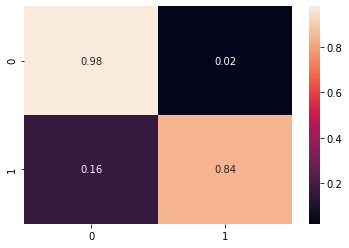

In [11]:
evaluate_model(clf_pipe, y_test, y_pred)

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_test_prob = clf_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_test_prob)
auc = roc_auc_score(y_test, y_pred_test_prob)
auc

0.9731243528193542

In [13]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8, 6))
    plt.title('ROC Curve', fontsize=15)
    plt.plot([0, 1], [0, 1], 'k-.')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.xticks(np.arange(0, 1, 0.05), rotation=90)
    plt.xlabel('False Positive Rates', fontsize=15)
    plt.ylabel('True Positive Rates', fontsize=15)
    plt.legend(loc='best')
    
    plt.show()

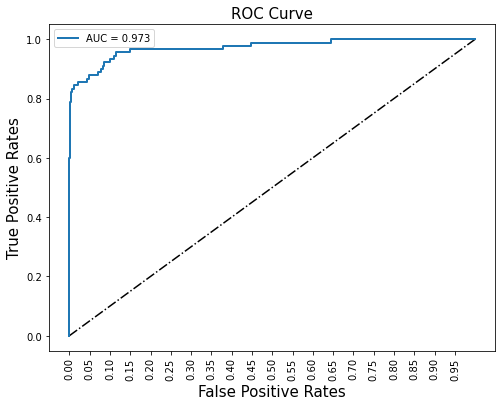

In [14]:
plot_roc_curve(fpr=fpr, tpr=tpr, label="AUC = %.3f" % auc)

Oversampling for unbalanced classes

In [15]:
from imblearn.over_sampling import RandomOverSampler

overS = RandomOverSampler(0.5)
X_train_ns, y_train_ns = overS.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

c:\users\zabir\python\lib\site-packages\imblearn\utils\_validation.py:587: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


The number of classes before fit Counter({0: 226597, 1: 383})
The number of classes after fit Counter({0: 226597, 1: 113298})


In [16]:
from sklearn.ensemble import RandomForestClassifier

RFclassifier = RandomForestClassifier()
RFclassifier.fit(X_train_ns, y_train_ns)

RandomForestClassifier()

In [17]:
y_pred = RFclassifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[56654     2]
 [   23    67]]
0.9995594403129736
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.97      0.74      0.84        90

    accuracy                           1.00     56746
   macro avg       0.99      0.87      0.92     56746
weighted avg       1.00      1.00      1.00     56746



In [18]:
y_pred_test_prob = RFclassifier.predict_proba(X_test)[:, 1]
fpr2, tpr2, threshold = roc_curve(y_test, y_pred_test_prob)
auc2 = roc_auc_score(y_test, y_pred_test_prob)
auc2

0.9474967837083059

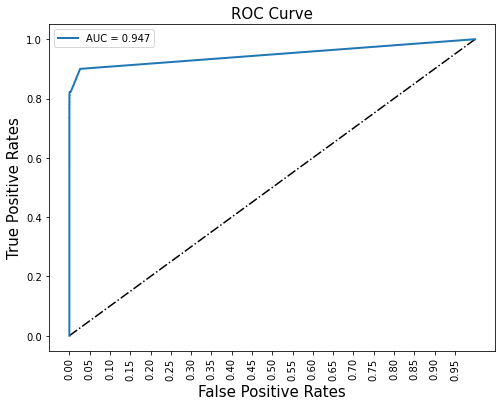

In [19]:
plot_roc_curve(fpr=fpr2, tpr=tpr2, label="AUC = %.3f" % auc2)

Ensemble Technique

In [20]:
from imblearn.ensemble import EasyEnsembleClassifier

In [21]:
ens = EasyEnsembleClassifier()
ens.fit(X_train,y_train)
y_pred = ens.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[55041  1615]
 [   11    79]]
0.971345997955803
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56656
           1       0.05      0.88      0.09        90

    accuracy                           0.97     56746
   macro avg       0.52      0.92      0.54     56746
weighted avg       1.00      0.97      0.98     56746



In [22]:
ens_recall = recall_score(y_test, y_pred)
ens_recall

0.8777777777777778

In [23]:
y_pred_test_prob = clf_pipe.predict_proba(X_test)[:, 1]
fpr3, tpr3, threshold = roc_curve(y_test, y_pred_test_prob)
auc3 = roc_auc_score(y_test, y_pred_test_prob)
auc3

0.9731243528193542

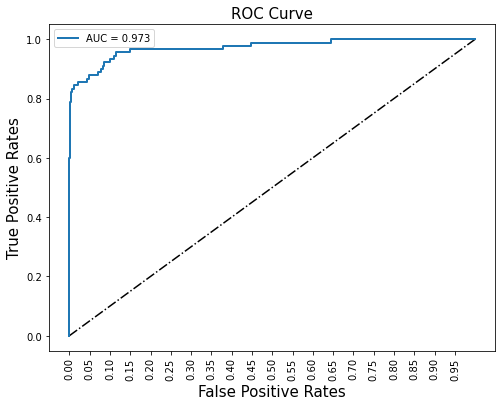

In [24]:
plot_roc_curve(fpr=fpr3, tpr=tpr3, label="AUC = %.3f" % auc3)

Naive Bayes Algorithm

In [25]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

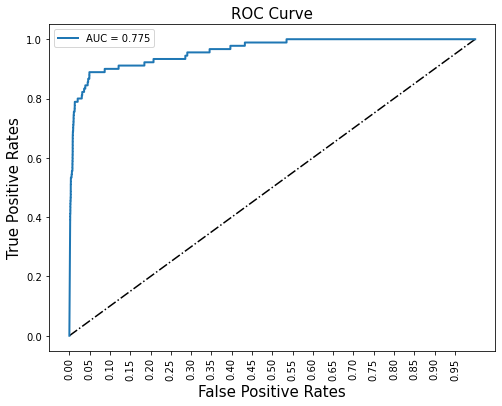

In [26]:
nb_pred = nb.predict(X_test)
nb_pred_proba = nb.predict_proba(X_test)[:, 1]
nb_auc = roc_auc_score(y_test, nb_pred)

fpr4, tpr4, threshold = roc_curve(y_test, nb_pred_proba)
plot_roc_curve(fpr4, tpr4, 'AUC = %.3f' % nb_auc)

In [27]:
nb_recall = recall_score(y_test, nb_pred)
nb_recall

0.5555555555555556

Support Vector Machine

In [ ]:
from sklearn.svm import SVC

svc_model = SVC(kernel='linear', probability=True)
svc_model.fit(X_train_ns, y_train_ns)

In [ ]:
svc_pred = svc_model.predict(X_test)
svc_recall = recall_score(y_test, svc_pred)
svc_recall

In [ ]:
svc_pred_prob = svc_model.predict_proba(X_test)[:, 1]
svc_auc = roc_auc_score(y_test, nb_pred)

fpr5, tpr5, threshold = roc_curve(y_test, svc_pred_proba)
plot_roc_curve(fpr5, tpr5, 'AUC = %.3f' % svc_auc)